In [1]:
# Desired sample rate
resample_rate=4

# Moving average
MA=10

# tsfresh window
max_window=10


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import ruptures as rpt 
import matplotlib.pyplot as plt
import matplotlib.legend_handler as handler
from sklearn.preprocessing import StandardScaler

from pandas.plotting import autocorrelation_plot

from tsfresh import extract_features, select_features, feature_extraction,extract_relevant_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute

from pywt import wavedec, waverec

import itertools
import os
import re

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [4]:
datapath=os.path.join('../data/unlabeled')

file='065-COMBINED-2022-10-24-13-41-52-1666650610-v1.4.3+lucina-buzz.csv' 
df=pd.read_csv(os.path.join(datapath,file))
 
sample_rate=25

# create an array of index values with a fixed step
time_index = np.linspace(0, (len(df)-1)/sample_rate, num=len(df))

# use this array as the index
df.index = time_index

# Resample the dataframe at (resample_rate) Hz
df_resampled = df.groupby(np.arange(len(df))//(sample_rate/resample_rate)).mean() 

print ('Original datapoints: ',len(df))
df=df_resampled
print ('Resampled datapoints: ',len(df))  

Original datapoints:  132666
Resampled datapoints:  21227


In [5]:
def filter_haar(data):
    #construct wavelets
    #wavelet='db4' 
    wavelet='haar'
    coeffs = wavedec(data.values, wavelet)
 
    # threshold
    threshold = 1 #( in percentage)

    # perform the thresholding
    coeffs_thresholded = [np.maximum(np.abs(c) - threshold, 0) * np.sign(c) for c in coeffs]
 
    # reconstruct time domain
    time_series_filtered = waverec(coeffs_thresholded, wavelet)
   
    return time_series_filtered


In [6]:
# Make an array with x,y,z acc and gyro and alpha_r and beta_r to use in ruptures
    
def get_signals(df,ts_start,ts_end,filter):
 
    if filter=='haar':
        acc_x_r_c=np.array(filter_haar(df['acc_x_r'][ts_start:ts_end]))
        acc_y_r_c=np.array(filter_haar(df['acc_y_r'][ts_start:ts_end]))
        acc_z_r_c=np.array(filter_haar(df['acc_z_r'][ts_start:ts_end]))

        acc_x_n_c=np.array(filter_haar(df['acc_x_n'][ts_start:ts_end]))
        acc_y_n_c=np.array(filter_haar(df['acc_y_n'][ts_start:ts_end])) 
        acc_z_n_c=np.array(filter_haar(df['acc_z_n'][ts_start:ts_end]))

        gyr_x_n_c=np.array(filter_haar(df['gyr_x_n'][ts_start:ts_end]))
        gyr_y_n_c=np.array(filter_haar(df['gyr_y_n'][ts_start:ts_end]))
        gyr_z_n_c=np.array(filter_haar(df['gyr_z_n'][ts_start:ts_end]))

        gyr_x_r_c=np.array(filter_haar(df['gyr_x_r'][ts_start:ts_end]))
        gyr_y_r_c=np.array(filter_haar(df['gyr_y_r'][ts_start:ts_end]))
        gyr_z_r_c=np.array(filter_haar(df['gyr_z_r'][ts_start:ts_end]))

        alpha_r_c = np.array(filter_haar(df['alpha_r'][ts_start:ts_end]))
        beta_r_c  = np.array(filter_haar(df['beta_r'][ts_start:ts_end]))
    
    else:
        acc_x_r_c=np.array(df['acc_x_r'][ts_start:ts_end])
        acc_y_r_c=np.array(df['acc_y_r'][ts_start:ts_end])
        acc_z_r_c=np.array(df['acc_z_r'][ts_start:ts_end])

        acc_x_n_c=np.array(df['acc_x_n'][ts_start:ts_end])
        acc_y_n_c=np.array(df['acc_y_n'][ts_start:ts_end])
        acc_z_n_c=np.array(df['acc_z_n'][ts_start:ts_end])

        gyr_x_n_c=np.array(df['gyr_x_n'][ts_start:ts_end])
        gyr_y_n_c=np.array(df['gyr_y_n'][ts_start:ts_end])
        gyr_z_n_c=np.array(df['gyr_z_n'][ts_start:ts_end])

        gyr_x_r_c=np.array(df['gyr_x_r'][ts_start:ts_end])
        gyr_y_r_c=np.array(df['gyr_y_r'][ts_start:ts_end])
        gyr_z_r_c=np.array(df['gyr_z_r'][ts_start:ts_end])

        alpha_r_c = np.array(df['alpha_r'][ts_start:ts_end])
        beta_r_c  = np.array(df['beta_r'][ts_start:ts_end])

    # Smoothing with Moving average of (MA)
    window = np.ones(MA*resample_rate) / (MA*resample_rate)
    acc_x_r_c = np.convolve(acc_x_r_c, window, mode='valid')
    acc_y_r_c = np.convolve(acc_y_r_c, window, mode='valid')
    acc_z_r_c = np.convolve(acc_z_r_c, window, mode='valid')

    acc_x_n_c = np.convolve(acc_x_n_c, window, mode='valid')
    acc_y_n_c = np.convolve(acc_y_n_c, window, mode='valid')
    acc_z_n_c = np.convolve(acc_z_n_c, window, mode='valid')

    gyr_x_r_c = np.convolve(gyr_x_r_c, window, mode='valid')
    gyr_y_r_c = np.convolve(gyr_y_r_c, window, mode='valid')
    gyr_z_r_c = np.convolve(gyr_z_r_c, window, mode='valid')

    gyr_x_n_c = np.convolve(gyr_x_n_c, window, mode='valid')
    gyr_y_n_c = np.convolve(gyr_y_n_c, window, mode='valid')
    gyr_z_n_c = np.convolve(gyr_z_n_c, window, mode='valid')

    alpha_r_c = np.convolve(alpha_r_c, window, mode='valid')
    beta_r_c = np.convolve(beta_r_c, window, mode='valid') 
    alpha_min_beta_c=alpha_r_c-beta_r_c

    # Normalise
    alpha_r = (alpha_r_c - alpha_r_c.min()) * (2/(alpha_r_c.max() - alpha_r_c.min())) - 1
    beta_r = (beta_r_c - beta_r_c.min()) * (2/(beta_r_c.max() - beta_r_c.min())) - 1
    alpha_min_beta = (alpha_min_beta_c - alpha_min_beta_c.min()) * (2/(alpha_min_beta_c.max() - alpha_min_beta_c.min())) - 1

    acc_x_n = (acc_x_n_c - acc_x_n_c.min()) * (2/(acc_x_n_c.max() - acc_x_n_c.min())) - 1 
    acc_y_n = (acc_y_n_c - acc_y_n_c.min()) * (2/(acc_y_n_c.max() - acc_y_n_c.min())) - 1
    acc_z_n = (acc_z_n_c - acc_z_n_c.min()) * (2/(acc_z_n_c.max() - acc_z_n_c.min())) - 1

    acc_x_r = (acc_x_r_c - acc_x_r_c.min()) * (2/(acc_x_r_c.max() - acc_x_r_c.min())) - 1 
    acc_y_r = (acc_y_r_c - acc_y_r_c.min()) * (2/(acc_y_r_c.max() - acc_y_r_c.min())) - 1
    acc_z_r = (acc_z_r_c - acc_z_r_c.min()) * (2/(acc_z_r_c.max() - acc_z_r_c.min())) - 1

    gyr_x_n = (gyr_x_n_c - gyr_x_n_c.min()) * (2/(gyr_x_n_c.max() - gyr_x_n_c.min())) - 1 
    gyr_y_n = (gyr_y_n_c - gyr_y_n_c.min()) * (2/(gyr_y_n_c.max() - gyr_y_n_c.min())) - 1
    gyr_z_n = (gyr_z_n_c - gyr_z_n_c.min()) * (2/(gyr_z_n_c.max() - gyr_z_n_c.min())) - 1

    gyr_x_r = (gyr_x_r_c - gyr_x_r_c.min()) * (2/(gyr_x_r_c.max() - gyr_x_r_c.min())) - 1 
    gyr_y_r = (gyr_y_r_c - gyr_y_r_c.min()) * (2/(gyr_y_r_c.max() - gyr_y_r_c.min())) - 1
    gyr_z_r = (gyr_z_r_c - gyr_z_r_c.min()) * (2/(gyr_z_r_c.max() - gyr_z_r_c.min())) - 1
  
 
    return acc_x_n,acc_y_n,acc_z_n,gyr_x_n,gyr_y_n,gyr_z_n,acc_x_r,acc_y_r,acc_z_r,gyr_x_r,gyr_y_r,gyr_z_r,alpha_r,beta_r,alpha_min_beta

In [7]:
signal_start= int(125/resample_rate)
signal_end  = 1000

acc_x_n,acc_y_n,acc_z_n,gyr_x_n,gyr_y_n,gyr_z_n,acc_x_r,acc_y_r,acc_z_r,gyr_x_r,gyr_y_r,gyr_z_r,alpha_r,beta_r,alpha_min_beta=get_signals(df,signal_start,signal_end,'haar')
 

In [8]:
def segment(stacked_data,window_size,penalty,method):

    #Window-based approach 
    if method=='window':
        algo = rpt.Window(width=window_size, model='rbf').fit(stacked_data)
        results = algo.predict(pen=penalty) 

    # Radial basis function kernel
    if method=='pelt':
        algo=rpt.Pelt(model='rbf').fit(stacked_data)
        results=algo.predict(pen=penalty) 
    
    return results

# Function to replace 2 nearby changepoints with one in the middle
def clean_results(all_results,method,datapoints):
    new_results = []
    i = 0
    while i < len(all_results) - 1:
        if all_results[i+1] - all_results[i] <= datapoints*resample_rate:
            if method=='avg':
                method_result = (all_results[i] + all_results[i+1])/2
            if method=='first':
                method_result=all_results[i]
            if method=='last':
                method_result=all_results[i+1]
            new_results.append(method_result)
            i += 2
        else:
            new_results.append(all_results[i])
            i += 1

    # Add the last value to the new list if it wasn't already added
    if i == len(all_results) - 1:
        new_results.append(all_results[-1])
    new_results = [*set(new_results)]
    new_results.sort()   
    return new_results

# Function to get the changepoint, fine-tuned from analysing labeled data
def get_changepoints():
    
    all_results=[]

    method='window'

    
    # Add acc_x_n and y from neck 
    penalty=2.1*resample_rate
    window_size=32*resample_rate
    stacked_data=np.vstack([alpha_r,beta_r,alpha_min_beta]).T 

    results=segment(stacked_data,window_size,penalty,method)
    all_results.append(results)

    # Add acc_x_n and y from neck 
    penalty=1.2*resample_rate
    window_size=32*resample_rate
    stacked_data=np.vstack([acc_x_n,acc_y_n]).T 

    results=segment(stacked_data,window_size,penalty,method)
    all_results.append(results)

    # Now add  acc_z_n  from neck 
    penalty=.87*resample_rate
    window_size=32*resample_rate
    stacked_data=np.vstack([acc_z_n]).T

    results=segment(stacked_data,window_size,penalty,method)
    all_results.append(results)

    # Now add acc from belt  
    penalty=.8*resample_rate
    window_size=32*resample_rate
    stacked_data=np.vstack([acc_x_r,acc_y_r,acc_z_r]).T

    results=segment(stacked_data,window_size,penalty,method)
    all_results.append(results)

    # Now add gyr_xxx_r
    penalty= 2.1*resample_rate
    window_size=32*resample_rate
    stacked_data=np.vstack([gyr_x_r,gyr_y_r,gyr_z_r]).T

    results=segment(stacked_data,window_size,penalty,method)
    all_results.append(results)

    # Now add  gyr_xxx_n  
    penalty= 2.1*resample_rate
    window_size=32*resample_rate
    stacked_data=np.vstack([gyr_x_n,gyr_y_n,gyr_z_n]).T

    results=segment(stacked_data,window_size,penalty,method)
    all_results.append(results)
 
    all_results = [item for sublist in all_results for item in sublist]
    all_results = [*set(all_results)]

    all_results.sort()   

    all_results=clean_results(all_results,'avg',5*resample_rate)
    all_results=clean_results(all_results,'avg',6*resample_rate)
    #all_results=clean_results(all_results,'last',9)

    return all_results
    


In [9]:
 
def plot_segment(signal1,signal2,signal3,signal4,signal5,signal6,results,range_start,range_end):


    # Draw the gyroscope plot
    fig,ax=plt.subplots(figsize=(16, 4))
    plt.title(f'Changepoints (window method)')

    axb=ax.twinx()

    signal_list=[signal1,signal2,signal3,signal4,signal5,signal6]
    ax.plot(signal_list[0],color='tab:red',linewidth=.25 , label ='x' , alpha=1)
    ax.plot(signal_list[1],color='tab:orange',linewidth=.25 , label ='y' , alpha=1)
    ax.plot(signal_list[2],color='tab:cyan',linewidth=.25 , label ='z'  , alpha=1)
    ax.set_xlim(range_start,range_end)
    axb.plot(signal_list[3],color='tab:green',linewidth=1.6 , label ='alpha')
    axb.plot(signal_list[4],color='tab:blue',linewidth=1.6 , label ='beta')
    axb.plot(signal_list[5],color='tab:red',linewidth=1.6 , label ='a_min_b')
    ax.legend(loc='upper left', bbox_to_anchor=(0, 1))
    axb.legend(loc='upper right', bbox_to_anchor=(1, 1))

    # Draw the change points
    cnt=int(0)
    for r in results:
        ax.axvline(x=r,color="tab:red",linewidth=3,linestyle=':')
        cnt+=1

    # Result
    print (cnt,'points detected')
    


In [10]:
# Function to plot a graph of a frame

def plot_frame(acc_x_n,acc_y_n,acc_z_n,gyr_x_n,gyr_y_n,gyr_z_n,alpha_r,beta_r,i):
    fig,ax=plt.subplots(figsize=(16, 4))

    plt.title(f'frame {i+1}')

    axb=ax.twinx()
    ax.plot(acc_x_n,color='tab:red',linewidth=.9 , label ='acc (x)', alpha=0.4)
    ax.plot(acc_y_n,color='tab:orange',linewidth=.9 , label ='acc (y)', alpha=0.4)
    ax.plot(acc_z_n,color='tab:cyan',linewidth=.9 , label ='acc (z)' , alpha=0.4)

    ax.plot(gyr_x_n,color='tab:red',linewidth=.9 , label ='gyr (x)', linestyle=':', alpha=0.66)
    ax.plot(gyr_y_n,color='tab:orange',linewidth=.9 , label ='gyr (y)', linestyle=':', alpha=0.66)
    ax.plot(gyr_z_n,color='tab:cyan',linewidth=.9 , label ='gyr (z)' , linestyle=':', alpha=0.66)

    axb.plot(alpha_r,color='tab:green',linewidth=1.6 , label ='alpha')
    axb.plot(beta_r,color='tab:blue',linewidth=1.6 , label ='beta')
    ax.legend(loc='upper left', bbox_to_anchor=(0, 1))
    axb.legend(loc='upper right', bbox_to_anchor=(1, 1))
    
    plt.show()


In [11]:
# Make frames from the change points

offset=signal_start
change_points=[]
start_point=[]
end_point=[]

results = get_changepoints()

for r in results:
    change_points.append(int(r))

start_point.append(0 + offset)
for i in range(0,len(change_points)-1,1):
    #print (i)
    end_point.append( change_points[i] + offset + resample_rate)
    start_point.append( change_points[i] + offset - resample_rate)
end_point.append(change_points[len(change_points)-1] + offset )
print (f'{len(change_points)} frames detected')
 

9 frames detected


9 points detected


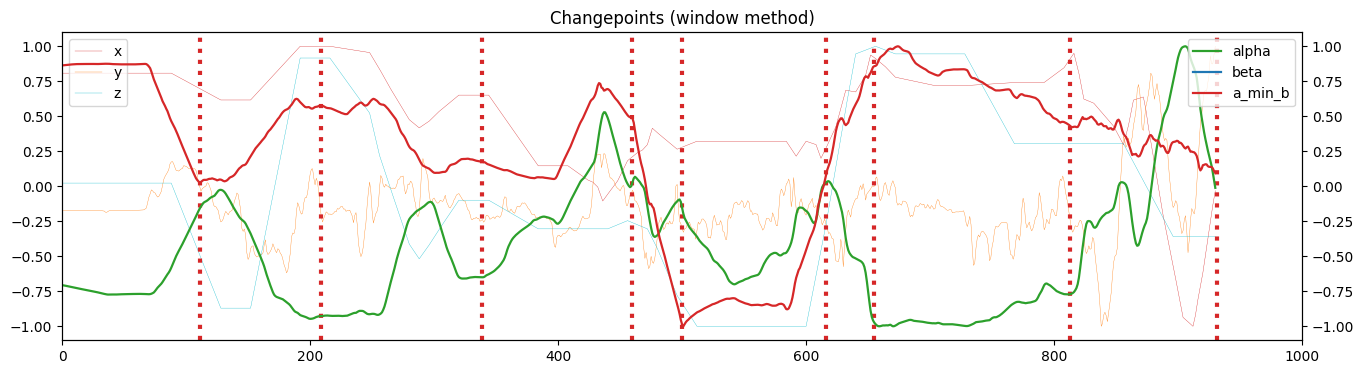

In [12]:
#PLOT THE GRAPH
range_start=000
range_end=len(df)
 
plot_segment(acc_x_n,gyr_x_n,acc_z_n,alpha_r,0,alpha_min_beta,results,range_start,range_end)

In [13]:
frame_data=[]

In [14]:
variables = {
    'acc_x_n': acc_x_n,
    'acc_y_n': acc_y_n,
    'acc_z_n': acc_z_n,
    'gyr_x_n': gyr_x_n,
    'gyr_y_n': gyr_y_n,
    'gyr_z_n': gyr_z_n,
    'acc_x_r': acc_x_r,
    'acc_y_r': acc_y_r,
    'acc_z_r': acc_z_r,
    'gyr_x_r': gyr_x_r,
    'gyr_y_r': gyr_y_r,
    'gyr_z_r': gyr_z_r,
    'alpha_r': alpha_r,
    'beta_r': beta_r,
    'alpha_min_beta': alpha_min_beta
}

def get_signals_range(variables, start, end):
    variables_range = {}
    for key, value in variables.items():
        variables_range[key] = value[start:end]
    return variables_range 
 


31 146


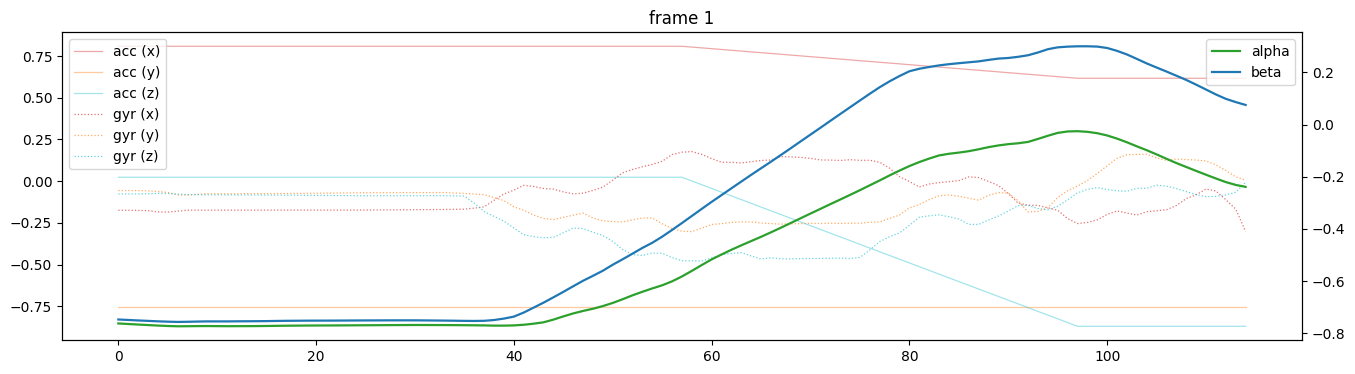

In [15]:
complete_df=pd.DataFrame()

for i in range(len(change_points)): 
    
    signals_frame = get_signals_range(variables, start_point[i],end_point[i])
    acc_x_n_frame = signals_frame['acc_x_n']
    acc_y_n_frame = signals_frame['acc_y_n']
    acc_z_n_frame = signals_frame['acc_z_n']
    gyr_x_n_frame = signals_frame['gyr_x_n']
    gyr_y_n_frame = signals_frame['gyr_y_n']
    gyr_z_n_frame = signals_frame['gyr_z_n']
    acc_x_r_frame = signals_frame['acc_x_r']
    acc_y_r_frame = signals_frame['acc_y_r']
    acc_z_r_frame = signals_frame['acc_z_r']
    gyr_x_r_frame = signals_frame['gyr_x_r']
    gyr_y_r_frame = signals_frame['gyr_y_r']
    gyr_z_r_frame = signals_frame['gyr_z_r']
    alpha_r_frame = signals_frame['alpha_r']
    beta_r_frame = signals_frame['beta_r']
    alpha_min_beta_frame = signals_frame['alpha_min_beta']

    frame_data.append(np.vstack([acc_x_n_frame,acc_y_n_frame,acc_z_n_frame,acc_x_r_frame,acc_y_r_frame,acc_z_r_frame,gyr_x_n_frame,gyr_y_n_frame,gyr_z_n_frame,gyr_x_r_frame,gyr_y_r_frame,gyr_z_r_frame,alpha_r_frame,beta_r_frame]).T)
    df1=pd.DataFrame(data=frame_data[i], columns=['acc_x_n','acc_y_n','acc_z_n','acc_x_r','acc_y_r','acc_z_r','gyr_x_n','gyr_y_n','gyr_z_n','gyr_x_r','gyr_y_r','gyr_z_r','alpha_r','beta_r'])
    df1['frame']=i
    df1['ts']=df1.index

    complete_df=pd.concat([complete_df,df1],axis=0)
    if i%15==0:
        print(start_point[i],end_point[i])
        plot_frame(acc_x_n_frame,acc_y_n_frame,acc_z_n_frame,gyr_x_n_frame,gyr_y_n_frame,gyr_z_n_frame,alpha_r_frame,beta_r_frame,i)

In [16]:
print(frame_data[0].shape)

(115, 14)


In [17]:
complete_df


,acc_x_n,acc_y_n,acc_z_n,acc_x_r,acc_y_r,acc_z_r,gyr_x_n,gyr_y_n,gyr_z_n,gyr_x_r,gyr_y_r,gyr_z_r,alpha_r,beta_r,frame,ts
0,0.808207,-0.755751,0.022911,1.0,-0.614707,1.0,-0.174755,-0.056695,-0.076950,-0.014709,-0.410099,0.163490,-0.762678,-0.747432,0,0
1,0.808207,-0.755751,0.022911,1.0,-0.614707,1.0,-0.174711,-0.056542,-0.077389,-0.014683,-0.411147,0.163828,-0.764776,-0.749318,0,1
2,0.808207,-0.755751,0.022911,1.0,-0.614707,1.0,-0.175940,-0.057250,-0.076661,-0.014815,-0.412194,0.164166,-0.766866,-0.751124,0,2
3,0.808207,-0.755751,0.022911,1.0,-0.614707,1.0,-0.177169,-0.057958,-0.075932,-0.014947,-0.413242,0.164504,-0.768835,-0.752818,0,3
4,0.808207,-0.755751,0.022911,1.0,-0.614707,1.0,-0.185210,-0.062315,-0.073525,-0.018144,-0.414289,0.164841,-0.770777,-0.754498,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,-0.255037,-1.000000,-0.358552,-1.0,-0.224228,-1.0,0.931998,0.405651,-0.738857,0.780210,0.702464,-0.365517,0.185083,0.418750,8,87
88,-0.194775,-1.000000,-0.358552,-1.0,-0.224228,-1.0,0.874720,0.494067,-0.814548,0.811156,0.646270,-0.618737,0.146114,0.387642,8,88
89,-0.134513,-1.000000,-0.358552,-1.0,-0.224228,-1.0,0.874012,0.529698,-0.767630,0.866941,0.762985,-0.750446,0.097321,0.354093,8,89
90,-0.082932,-1.000000,-0.358552,-1.0,-0.224228,-1.0,0.943438,0.566718,-0.749501,0.875939,0.783485,-0.757149,0.043776,0.321814,8,90


In [18]:
complete_df.to_csv(f'../data/processed/unlabeled/frames/frames_{file}')

In [19]:

extracted_features={}
signals=['acc_x_n','acc_y_n','acc_z_n','gyr_x_n','gyr_y_n','gyr_z_n','alpha_r','beta_r'] 
df_ef=pd.DataFrame()

for i in range(len(frame_data)):

    df_fd=pd.DataFrame(data=frame_data[i], columns=['acc_x_n','acc_y_n','acc_z_n','acc_x_r','acc_y_r','acc_z_r','gyr_x_n','gyr_y_n','gyr_z_n','gyr_x_r','gyr_y_r','gyr_z_r','alpha_r','beta_r'])
    df_fd['frame']=i
    df_fd['ts']=df_fd.index

    signals=columns=['acc_x_n','acc_y_n','acc_z_n','acc_x_r','acc_y_r','acc_z_r','gyr_x_n','gyr_y_n','gyr_z_n','gyr_x_r','gyr_y_r','gyr_z_r','alpha_r','beta_r']
    extracted_features={}   
        
    cnt=int(0)
    for signal in signals:
        if __name__ == "__main__":
            extracted_features[signal] = extract_features(df_fd, 
                                column_id="frame", column_sort="ts", column_value=signal, 
                                impute_function=impute, show_warnings=False, 
                                n_jobs=0)

            extracted_features[signal]['frame']=i+1
            extracted_features[signal]['signal']=signal
            df_ef_signal=pd.DataFrame(data=extracted_features[signal].values)
            df_ef=pd.concat([df_ef,df_ef_signal],axis=0)


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


In [20]:
# Make clean column names for df_ef 
clean_columns=[]
columns=extracted_features['acc_x_n'].columns
for column in columns:
    clean_column=re.sub('acc_x_n__','',column)
    clean_columns.append(clean_column)
df_ef.columns=clean_columns
df_ef.reset_index(drop=True, inplace=True)
df_ef

,variance_larger_than_standard_deviation,has_duplicate_max,has_duplicate_min,has_duplicate,sum_values,abs_energy,mean_abs_change,mean_change,mean_second_derivative_central,median,...,fourier_entropy__bins_100,permutation_entropy__dimension_3__tau_1,permutation_entropy__dimension_4__tau_1,permutation_entropy__dimension_5__tau_1,permutation_entropy__dimension_6__tau_1,permutation_entropy__dimension_7__tau_1,query_similarity_count__query_None__threshold_0.0,mean_n_absolute_max__number_of_maxima_7,frame,signal
0,0.0,1.0,1.0,1.0,85.751505,64.626454,0.001682,-0.001682,0.0,0.808207,...,0.260386,0.738017,0.829008,0.920967,1.0139,1.107809,0.0,0.808207,1,acc_x_n
1,0.0,1.0,1.0,1.0,-86.911347,65.683324,0.0,0.0,0.0,-0.755751,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.755751,1,acc_y_n
2,0.0,1.0,1.0,1.0,-30.862336,23.130935,0.007836,-0.007836,0.0,0.022911,...,0.260386,0.738017,0.829008,0.920967,1.0139,1.107809,0.0,0.870346,1,acc_z_n
3,0.0,1.0,1.0,1.0,115.0,115.0,0.0,0.0,0.0,1.0,...,0.173897,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,1.0,1,acc_x_r
4,0.0,1.0,1.0,1.0,-70.691336,43.454478,0.0,0.0,0.0,-0.614707,...,0.173897,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.614707,1,acc_y_r
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,0.0,0.0,0.0,0.0,19.966548,32.826861,0.064094,0.019869,0.000295,0.383859,...,0.889528,1.453416,2.22306,2.878092,3.370394,3.777481,0.0,0.968552,9,gyr_x_r
122,0.0,0.0,0.0,0.0,3.368249,17.558132,0.136537,0.018238,0.000994,0.029012,...,2.224638,1.710555,2.876861,3.80271,4.342339,4.438228,0.0,0.899819,9,gyr_y_r
123,0.0,0.0,0.0,0.0,-3.297758,18.739318,0.110478,-0.013315,-0.000499,0.013104,...,1.232267,1.631833,2.655722,3.508759,4.05341,4.297101,0.0,0.873716,9,gyr_z_r
124,0.0,0.0,0.0,0.0,22.863525,24.187316,0.034456,0.002252,-0.000353,0.156119,...,0.40905,0.834233,0.994413,1.156073,1.319137,1.483511,0.0,0.990698,9,alpha_r


In [21]:
df_ef['length'][0:15]

0     115.0
1     115.0
2     115.0
3     115.0
4     115.0
5     115.0
6     115.0
7     115.0
8     115.0
9     115.0
10    115.0
11    115.0
12    115.0
13    115.0
14    105.0
Name: length, dtype: object

In [22]:
clean_columns

['variance_larger_than_standard_deviation',
 'has_duplicate_max',
 'has_duplicate_min',
 'has_duplicate',
 'sum_values',
 'abs_energy',
 'mean_abs_change',
 'mean_change',
 'mean_second_derivative_central',
 'median',
 'mean',
 'length',
 'standard_deviation',
 'variation_coefficient',
 'variance',
 'skewness',
 'kurtosis',
 'root_mean_square',
 'absolute_sum_of_changes',
 'longest_strike_below_mean',
 'longest_strike_above_mean',
 'count_above_mean',
 'count_below_mean',
 'last_location_of_maximum',
 'first_location_of_maximum',
 'last_location_of_minimum',
 'first_location_of_minimum',
 'percentage_of_reoccurring_values_to_all_values',
 'percentage_of_reoccurring_datapoints_to_all_datapoints',
 'sum_of_reoccurring_values',
 'sum_of_reoccurring_data_points',
 'ratio_value_number_to_time_series_length',
 'sample_entropy',
 'maximum',
 'absolute_maximum',
 'minimum',
 'benford_correlation',
 'time_reversal_asymmetry_statistic__lag_1',
 'time_reversal_asymmetry_statistic__lag_2',
 'time_

In [23]:
for column in df_ef.columns:
    new_columns=[signal]

In [24]:
# Function that returns the extracted features for all frames in a file as 1 dimensional elements

def get_extracted_features_table(df):

    # Create the columns with the features for each signal
    signal_list=['acc_x_n','acc_y_n','acc_z_n','acc_x_r','acc_y_r','acc_z_r','gyr_x_n','gyr_y_n','gyr_z_n','gyr_x_r','gyr_y_r','gyr_z_r','alpha_r','beta_r']

    big_vector_columns=[]

    # Loop over the signals
    for signal in signal_list:

        new_columns=[]

        # Make new column names for each signal
        for column in df.columns.drop(['frame','signal']):
            new_column=str(signal+'_'+column)
            new_columns.append(new_column)

        # Add to the column list
        big_vector_columns=big_vector_columns+new_columns

    # Create the big vector dataframe
    df_ef_big_vector=pd.DataFrame()
    frame=int(0)
    frame_features={}

    # Loop over the frames
    for frame_nr in df['frame'].unique():
        signal_features=[]

        # Loop over the signals
        for i in range(0,len(signal_list)):
            #print (frame_nr,(i+frame_nr*14)-14)
            df_row=df.loc[(df['frame'] == frame_nr) & (df['signal'] == signal_list[i])].drop(['frame','signal'],axis=1)
                 
            signal_features.append(df_row.values)
         
        # Flatten the signal_features
        for iterations in range(2):
            signal_features=list(itertools.chain.from_iterable(signal_features)) 
        # Append the signal_features to the frame features dictionary
        frame_features[frame_nr]=signal_features
        #print (frame_features[frame_nr])
        #frame_features[frame_nr]=list(itertools.chain.from_iterable(signal_features[frame_nr]))
    
    df_frame_features=pd.DataFrame(frame_features)
    # Concatenate all the features per frame
    for frame_nr in df['frame'].unique():
        df_ef_big_vector=pd.concat([df_ef_big_vector,pd.DataFrame(data=frame_features[frame_nr])],axis=1)

    # Transpose and add column names
    df_ef_big_vector=df_ef_big_vector.T
    df_ef_big_vector.columns=big_vector_columns

    # Reset the index
    df_ef_big_vector.reset_index(inplace=True,drop=True)
    df_ef_big_vector['frame']=df_ef_big_vector.index+1
    return df_ef_big_vector   

In [25]:
df_ef_big_vector=get_extracted_features_table(df_ef)
df_ef_big_vector

,acc_x_n_variance_larger_than_standard_deviation,acc_x_n_has_duplicate_max,acc_x_n_has_duplicate_min,acc_x_n_has_duplicate,acc_x_n_sum_values,acc_x_n_abs_energy,acc_x_n_mean_abs_change,acc_x_n_mean_change,acc_x_n_mean_second_derivative_central,acc_x_n_median,...,beta_r_fourier_entropy__bins_10,beta_r_fourier_entropy__bins_100,beta_r_permutation_entropy__dimension_3__tau_1,beta_r_permutation_entropy__dimension_4__tau_1,beta_r_permutation_entropy__dimension_5__tau_1,beta_r_permutation_entropy__dimension_6__tau_1,beta_r_permutation_entropy__dimension_7__tau_1,beta_r_query_similarity_count__query_None__threshold_0.0,beta_r_mean_n_absolute_max__number_of_maxima_7,frame
0,0.0,1.0,1.0,1.0,85.751505,64.626454,0.001682,-0.001682,0.000000,0.808207,...,0.173897,0.173897,0.803198,1.003333,1.202580,1.364905,1.512187,0.0,0.755505,1
1,0.0,1.0,1.0,1.0,91.273694,81.655576,0.004039,0.003338,-0.000007,0.964917,...,0.279704,0.279704,1.086789,1.556700,1.887246,2.106788,2.275195,0.0,0.721772,2
2,0.0,0.0,0.0,1.0,85.507440,57.103045,0.008350,-0.004933,-0.000041,0.610362,...,0.278445,0.372278,0.872905,1.124789,1.271014,1.403716,1.515958,0.0,0.725711,3
3,0.0,0.0,0.0,1.0,22.341211,6.005770,0.008885,-0.000823,0.000021,0.145921,...,0.425514,0.850210,1.027099,1.411406,1.796861,2.144801,2.448725,0.0,0.582732,4
4,0.0,0.0,0.0,1.0,14.781971,4.568744,0.002619,-0.000205,0.000080,0.321730,...,0.167944,0.606025,0.648791,0.730871,0.814222,0.898662,0.983925,0.0,0.750616,5
5,0.0,0.0,0.0,1.0,47.838834,21.626802,0.008341,0.004416,0.000149,0.321730,...,0.243759,0.463131,0.909052,1.148734,1.388729,1.628788,1.838480,0.0,0.584367,6
6,0.0,0.0,0.0,0.0,38.236437,31.291206,0.008908,0.000628,-0.000185,0.788388,...,0.344598,0.681610,0.938397,1.127507,1.320509,1.517218,1.621786,0.0,0.995676,7
7,0.0,0.0,0.0,1.0,119.569096,87.870227,0.004713,-0.001893,-0.000026,0.733585,...,0.130282,0.307882,0.869767,1.183482,1.476893,1.736961,1.981932,0.0,0.932287,8
8,0.0,0.0,0.0,0.0,-7.091267,29.886808,0.034879,-0.006077,0.000344,-0.015263,...,0.205471,0.439978,0.803219,0.946682,1.106912,1.268410,1.431059,0.0,0.983609,9


In [26]:
df_ef_big_vector.to_csv(f'../data/processed/unlabeled/ts/ts_feat_{file}')
